In [1]:
import os 
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import cutde.fullspace as FS
from scipy.spatial.transform import Rotation as R
from scipy.linalg import svd, lstsq
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import pchip_interpolate, interp1d
from scipy.signal import resample, detrend, resample_poly
from operator import itemgetter
import matplotlib.dates as mdates
from datetime import datetime, timedelta


In [2]:
# Read in well geometry
wellcols=np.arange(12)
WellGeom=pd.read_excel('/home/spri902/Collab_metadata/Well_Points.xlsx',header=0,usecols=wellcols)
WellGeom.columns = WellGeom.columns.str.replace(' ','')
# convert from feet to meters
WellGeom.x = WellGeom.x/3.28084
WellGeom.y = WellGeom.y/3.28084
WellGeom.z = WellGeom.z/3.28084
# pull out the monitoring wells
mwells=[]
wellList = ['E1-OB','E1-OT','E1-PDT','E1-PDB','E1-PST','E1-PSB']
for i in wellList:
    tmpwell = WellGeom[WellGeom["HoleID"]== i]
    tmpwell = tmpwell.iloc[:,0:6]
    mwells.append(tmpwell)
mwells = pd.concat(mwells)
# pull out the injector and production wells
swells=[]
wellList = ['E1-I','E1-P']
for i in wellList:
    tmpwell = WellGeom[WellGeom["HoleID"]== i]
    tmpwell = tmpwell.iloc[:,0:6]
    swells.append(tmpwell)
swells = pd.concat(swells)

# map DAS channel data to actual well coordinates
PDTchans = np.r_[1271:1388]
PDBchans = np.r_[1091:1210]

# take every 10th point (1 meter spacing along well)
PDBpnts = mwells[mwells['HoleID'] == 'E1-PDB' ].iloc[0::10,:] 
PDTpnts = mwells[mwells['HoleID'] == 'E1-PDT' ].iloc[0::10,:]

# make some points for a path between seismic source and receiver
PSTsrc = [806.8853425197, -1305.7826706037, 113.65265]
PDBrec = [820.9063674541, -1294.9104317585, 101.7651076]
sx = np.linspace(PSTsrc[0],PDBrec[0],len(PDTpnts))
sy = np.linspace(PSTsrc[1],PDBrec[1],len(PDTpnts))
sz = np.linspace(PSTsrc[2],PDBrec[2],len(PDTpnts))
srcrecpts = np.array([sx,sy,sz]).T

In [3]:
# switch dir to where the fracture points are
os.chdir('/home/spri902/EGS_Collab/4850/fractures/')
# Read in xyz points for OTP-connector and hydrofracs
with open('frac_plane_points.npy','rb') as f:
    x = np.load(f)

# Pull out OTP-connector points
otp = x[0:80,:]
# otp = np.array(itemgetter(19,39,59)(x))
ctr = otp.mean(axis=0)

# fit the OT-P fracture plane with 4 of the 80 points
seedPnts = np.array([x[0,0],x[0,1],x[0,2],
x[19,0],x[19,1],x[19,2],
x[39,0],x[39,1],x[39,2],
x[59,0],x[59,1],x[59,2]]).reshape(4,3)

In [4]:
# write a function to fit a plane to the boundary points of the fracture
# this actually finds the normal vector to the plane
def planeFit(points):
    """
    p, n = planeFit(points)

    Given an array, points, of shape (d,n)
    points in d-dimensional space,
    fit a d-dimensional plane to the points.
    Return a point, p, on the plane (the point-cloud centroid),
    and the normal vector to the plane, n.
    """
    points = np.reshape(points, (np.shape(points)[0], -1)) # Collapse trailing dimensions
    assert points.shape[0] <= points.shape[1], "There are only {} points in {} dimensions.".format(points.shape[1], points.shape[0])
    ctr = points.mean(axis=1)
    x = points - ctr[:,np.newaxis]
    # M = np.dot(x, x.T) # Could also use np.cov(x) here.
    M = np.cov(x)
    return ctr, svd(M)[0][:,-1]

# get the center and the normal vector to the plane
pctr, normvec = planeFit(seedPnts.T)
# pctr, normvec = planeFit(otp.T)

# do the dot product of the center point and the normal vector to find the offset
fittedPlane = -pctr.dot(normvec)

# create points in the plane using the plane EQ
# Ax + By + Cz + D = 0 ... where A, B, C and D are the normal vector components and offset
xb = np.sort(otp[:,0].copy()) # points in the x direction of the plane
zb = np.sort(otp[:,2].copy()) # points in the z direction of the plane
xx,zz = np.meshgrid(xb,zb)

# use x and z points in the plane to find the y points
# this works much better than using x and y to find z 

# now use Ax + By + Cz + D = 0
# y = -(Ax + Cz + D) / B
yy = -(normvec[0] * xx + normvec[2] * zz + fittedPlane) * 1. /normvec[1] 

In [5]:
# well coordinates
# obsx = np.linspace(-2,2,100)
pdtobsx = np.array(PDTpnts.x) # well PDT
pdbobsx = np.array(PDBpnts.x) # well PDB
# obsy = np.linspace(-2,2,100)
pdtobsy = np.array(PDTpnts.y)
pdbobsy = np.array(PDBpnts.y)
# obsz = np.linspace(-2,2,100)
pdtobsz = np.array(PDTpnts.z)
pdbobsz = np.array(PDBpnts.z)
# pts = np.array([obsx, obsy, 0 * obsz]).reshape((3, -1)).T.copy()
pdtpts = np.array([pdtobsx, pdtobsy,  pdtobsz]).reshape((3, -1)).T.copy()
pdbpts = np.array([pdbobsx, pdbobsy,  pdbobsz]).reshape((3, -1)).T.copy()

In [ ]:
# fig=plt.figure()
# ax = fig.add_subplot(projection='3d')
# # ax.scatter(obsx,obsy,obsz)
# # ax.plot(fault_pts[:,0],fault_pts[:,1],fault_pts[:,2],'k')
# # ax.scatter(pts[:,0],pts[:,1],pts[:,2],'.k')
# # ax.scatter(C[0],C[1],C[2],'.r')
# ax.scatter(xx,yy,zz)
# xs,ys,zs = np.meshgrid(np.linspace(np.min(xx),np.max(xx),51),np.linspace(np.min(yy),np.max(yy),51),np.linspace(np.min(zz),np.max(zz),51))
# fig = go.Figure()
# # fig.add_scatter3d(x=xx.flatten(), y=yy.flatten(), z=zz.flatten(),mode='markers',
# #   marker=dict(
# #         size=5,
# #         color='red',
# #         opacity=0.8))
# fig.add_scatter3d(x=surf_pts[:,0], y=surf_pts[:,1],z=surf_pts[:,2],mode='markers',
#   marker=dict(
#         size=3,
#         color='red',
#         opacity=0.8))
# fig.add_trace(go.Mesh3d(x=xx.flatten(),y=yy.flatten(),z=zz.flatten(),
#         opacity=0.1,
#         color='yellow'))

In [6]:
# Create a mesh for Ben Thompson's strain matrix function in cutde
# surf_L = 4000
n_els_per_dim = 80
# mesh_xs = np.linspace(-surf_L, surf_L, n_els_per_dim + 1)
# mesh_ys = np.linspace(-surf_L, surf_L, n_els_per_dim + 1)
mesh_xs = np.linspace(np.min(xx),np.max(xx),n_els_per_dim + 1)
mesh_ys = np.linspace(np.min(yy),np.max(yy),n_els_per_dim + 1)
mesh_zs = np.linspace(np.min(zz),np.max(zz),n_els_per_dim + 1)
mesh_xg, mesh_yg, mesh_zg = np.meshgrid(mesh_xs, mesh_ys,mesh_zs)
surf_pts = np.array([mesh_xg, mesh_yg, mesh_zg]).reshape((3, -1)).T.copy()
# surf_pts = np.array([xx,yy,zz]).reshape((-3,1)).T.copy()

surf_tris = []
nx = ny = n_els_per_dim + 1
idx = lambda i, j: i * ny + j
for i in range(n_els_per_dim):
    for j in range(n_els_per_dim):
        x1, x2 = mesh_xs[i : i + 2]
        y1, y2 = mesh_ys[j : j + 2]
        surf_tris.append([idx(i, j), idx(i + 1, j), idx(i + 1, j + 1)])
        surf_tris.append([idx(i, j), idx(i + 1, j + 1), idx(i, j + 1)])
surf_tris = np.array(surf_tris, dtype=np.int64)

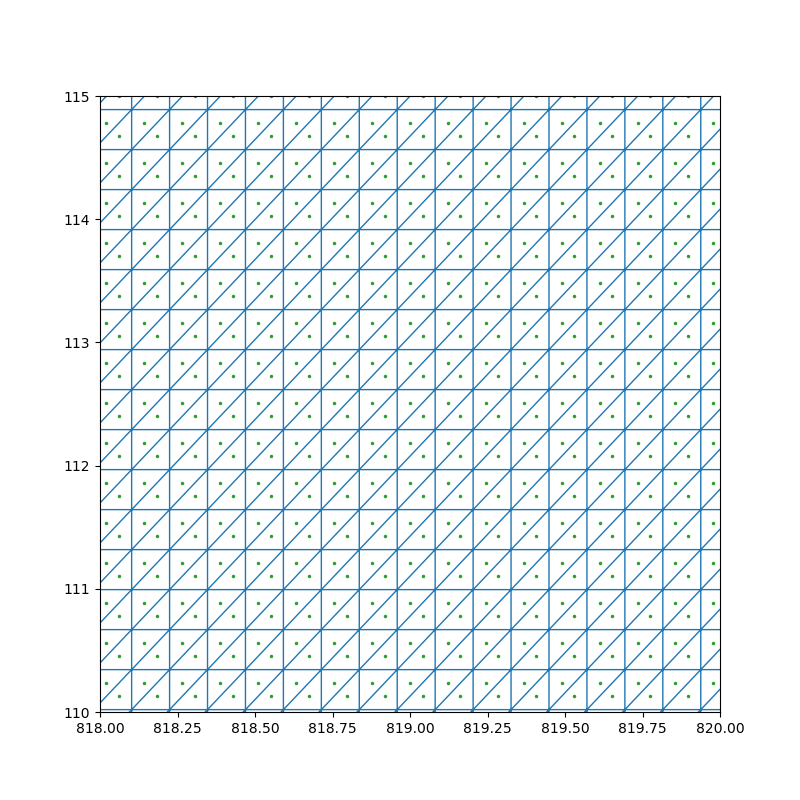

In [7]:
# Find the mesh vertices and centroids and plot
surf_tri_pts = surf_pts[surf_tris]
surf_centroids = np.mean(surf_tri_pts, axis=1)
plt.figure(figsize=(8,8))
plt.triplot(surf_pts[:, 0], surf_pts[:, 2], surf_tris, linewidth=1.0)
plt.plot(surf_centroids[:, 0], surf_centroids[:, 2], ".", markersize=3)
plt.xlim([818,820])
plt.ylim([110, 115])
plt.show()

In [8]:
# Call strain matrix function from Ben's FullSpace code 
# output dimensions are strain_mat = (num_obs, strain_tensor_component, num_triangles, slip mode)
# strain tensor comps: 0 = xx, 1 = yy, 2 = zz, 3 = xy, 4 = xz, 5 = yz
# slip modes: 0 = strike slip, 1 = dip slip, 2 = tensile

# disp_mat = FS.disp_matrix(obs_pts=pts, tris=fault_pts[fault_tris], nu=0.24)
pdtstrain_mat = FS.strain_matrix(obs_pts=pdtpts, tris=surf_pts[surf_tris], nu=0.24)
pdbstrain_mat = FS.strain_matrix(obs_pts=pdbpts, tris=surf_pts[surf_tris], nu=0.24)

# Sum over axis 2 to add up all the triangular elements for each mode (we dont do this in the final inversion bc we invert for each element)
pdtstrain_grid1 = np.sum(pdtstrain_mat[:,:,:,0],axis=2)
pdtstrain_grid2 = np.sum(pdtstrain_mat[:,:,:,1],axis=2)
pdtstrain_grid3 = np.sum(pdtstrain_mat[:,:,:,2],axis=2)

pdbstrain_grid1 = np.sum(pdbstrain_mat[:,:,:,0],axis=2)
pdbstrain_grid2 = np.sum(pdbstrain_mat[:,:,:,1],axis=2)
pdbstrain_grid3 = np.sum(pdbstrain_mat[:,:,:,2],axis=2)


# slip1 = np.array([[1, 0, 0], [1, 0, 0]])
# slip2 = np.array([[0, 1, 0], [0, 1, 0]])
# slip3 = np.array([[0, 0, 1], [0, 0, 1]])


# # disp = disp_mat.reshape((-1, 6)).dot(slip.flatten())
# strain1 = strain_mat.reshape((-1, 6)).dot(slip1.flatten())
# strain2 = strain_mat.reshape((-1, 6)).dot(slip2.flatten())
# strain3 = strain_mat.reshape((-1, 6)).dot(slip3.flatten())

# # # disp_grid = disp.reshape((*obsx.shape, 3))
# strain_grid1 = strain1.reshape((80, 6)) # This is strike slip
# strain_grid2 = strain2.reshape((80, 6)) # This is dip slip
# strain_grid3 = strain3.reshape((80, 6)) # This is opening

In [9]:
# Project fiber strains into tangent, normal and binormal vectors

# find unit tangent vector 
pdttannorm = np.linalg.norm(np.diff(pdtpts,axis=0),axis=1)
pdttanvec=(np.diff(pdtpts,axis=0).T/pdttannorm)

# find unit normal vector
pdtnnorm = np.linalg.norm(np.diff(pdttanvec,axis=1),axis=0)
pdtnm = np.diff(pdttanvec,axis=1)/pdtnnorm
pdtnm = np.hstack((pdtnm,pdtnm[:,-1].reshape(3,1)))

# find unit binormal vector
pdtbm = np.cross(pdttanvec,pdtnm,axisa=0,axisb=0)

pdttanvec = pdttanvec.T
pdtnm = pdtnm.T
# same for another well (PDB)
pdbtannorm = np.linalg.norm(np.diff(pdbpts,axis=0),axis=1)
pdbtanvec=(np.diff(pdbpts,axis=0).T/pdbtannorm)
# find unit normal vector
pdbnnorm = np.linalg.norm(np.diff(pdbtanvec,axis=1),axis=0)
pdbnm = np.diff(pdbtanvec,axis=1)/pdbnnorm
pdbnm = np.hstack((pdbnm,pdbnm[:,-1].reshape(3,1)))
# find unit binormal vector
pdbbm = np.cross(pdbtanvec,pdbnm,axisa=0,axisb=0)

pdbtanvec = pdbtanvec.T
pdbnm = pdbnm.T

In [10]:
# Rotate the strain tensor for well PDT
pdtstrain_grid_new1 = np.zeros_like(pdtstrain_grid1)
pdtstrain_grid_new2 = np.zeros_like(pdtstrain_grid2)
pdtstrain_grid_new3 = np.zeros_like(pdtstrain_grid3)

for position_index in range(len(pdtobsx)-1):
    e1 = np.zeros((3,3))
    e1[0,0] = pdtstrain_grid1[position_index,0]
    e1[0,1] = pdtstrain_grid1[position_index,1]
    e1[0,2] = pdtstrain_grid1[position_index,2]
    e1[1,1] = pdtstrain_grid1[position_index,3]
    e1[1,2] = pdtstrain_grid1[position_index,4]
    e1[2,2] = pdtstrain_grid1[position_index,5]
    # r = R.from_rotvec([anglex[position_index],anglex[position_index],anglex[position_index]])
    # Q = r.as_matrix()
    Q = np.array([pdttanvec[position_index,:],pdtnm[position_index,:],pdtbm[position_index,:]])
    # Q = np.array(tanvec[position_index,:])
    enew1 = Q*e1*Q.T
    pdtstrain_grid_new1[position_index,0] = enew1[0,0]
    pdtstrain_grid_new1[position_index,1] = enew1[0,1]
    pdtstrain_grid_new1[position_index,2] = enew1[0,2]
    pdtstrain_grid_new1[position_index,3] = enew1[1,1]
    pdtstrain_grid_new1[position_index,4] = enew1[1,2]
    pdtstrain_grid_new1[position_index,5] = enew1[2,2]

    e2 = np.zeros((3,3))
    e2[0,0] = pdtstrain_grid2[position_index,0]
    e2[0,1] = pdtstrain_grid2[position_index,1]
    e2[0,2] = pdtstrain_grid2[position_index,2]
    e2[1,1] = pdtstrain_grid2[position_index,3]
    e2[1,2] = pdtstrain_grid2[position_index,4]
    e2[2,2] = pdtstrain_grid2[position_index,5]
    # r = R.from_rotvec([anglex[position_index],anglex[position_index],anglex[position_index]])
    # Q = r.as_matrix()
    Q = np.array([pdttanvec[position_index,:],pdtnm[position_index,:],pdtbm[position_index,:]])
    # Q = np.array(tanvec[position_index,:])
    enew2 = Q*e2*Q.T
    pdtstrain_grid_new2[position_index,0] = enew2[0,0]
    pdtstrain_grid_new2[position_index,1] = enew2[0,1]
    pdtstrain_grid_new2[position_index,2] = enew2[0,2]
    pdtstrain_grid_new2[position_index,3] = enew2[1,1]
    pdtstrain_grid_new2[position_index,4] = enew2[1,2]
    pdtstrain_grid_new2[position_index,5] = enew2[2,2]

    e3 = np.zeros((3,3))
    e3[0,0] = pdtstrain_grid3[position_index,0]
    e3[0,1] = pdtstrain_grid3[position_index,1]
    e3[0,2] = pdtstrain_grid3[position_index,2]
    e3[1,1] = pdtstrain_grid3[position_index,3]
    e3[1,2] = pdtstrain_grid3[position_index,4]
    e3[2,2] = pdtstrain_grid3[position_index,5]
    # r = R.from_rotvec([anglex[position_index],anglex[position_index],anglex[position_index]])
    # Q = r.as_matrix()
    Q = np.array([pdttanvec[position_index,:],pdtnm[position_index,:],pdtbm[position_index,:]])
    # Q = np.array(tanvec[position_index,:])
    enew3 = Q*e3*Q.T
    pdtstrain_grid_new3[position_index,0] = enew3[0,0]
    pdtstrain_grid_new3[position_index,1] = enew3[0,1]
    pdtstrain_grid_new3[position_index,2] = enew3[0,2]
    pdtstrain_grid_new3[position_index,3] = enew3[1,1]
    pdtstrain_grid_new3[position_index,4] = enew3[1,2]
    pdtstrain_grid_new3[position_index,5] = enew3[2,2]

In [11]:
# Rotate the strain tensor for well PDB
pdbstrain_grid_new1 = np.zeros_like(pdbstrain_grid1)
pdbstrain_grid_new2 = np.zeros_like(pdbstrain_grid2)
pdbstrain_grid_new3 = np.zeros_like(pdbstrain_grid3)

for position_index in range(len(pdbobsx)-1):
    e1 = np.zeros((3,3))
    e1[0,0] = pdbstrain_grid1[position_index,0]
    e1[0,1] = pdbstrain_grid1[position_index,1]
    e1[0,2] = pdbstrain_grid1[position_index,2]
    e1[1,1] = pdbstrain_grid1[position_index,3]
    e1[1,2] = pdbstrain_grid1[position_index,4]
    e1[2,2] = pdbstrain_grid1[position_index,5]
    # r = R.from_rotvec([anglex[position_index],anglex[position_index],anglex[position_index]])
    # Q = r.as_matrix()
    Q = np.array([pdbtanvec[position_index,:],pdbnm[position_index,:],pdbbm[position_index,:]])
    # Q = np.array(tanvec[position_index,:])
    enew1 = Q*e1*Q.T
    pdbstrain_grid_new1[position_index,0] = enew1[0,0]
    pdbstrain_grid_new1[position_index,1] = enew1[0,1]
    pdbstrain_grid_new1[position_index,2] = enew1[0,2]
    pdbstrain_grid_new1[position_index,3] = enew1[1,1]
    pdbstrain_grid_new1[position_index,4] = enew1[1,2]
    pdbstrain_grid_new1[position_index,5] = enew1[2,2]

    e2 = np.zeros((3,3))
    e2[0,0] = pdbstrain_grid2[position_index,0]
    e2[0,1] = pdbstrain_grid2[position_index,1]
    e2[0,2] = pdbstrain_grid2[position_index,2]
    e2[1,1] = pdbstrain_grid2[position_index,3]
    e2[1,2] = pdbstrain_grid2[position_index,4]
    e2[2,2] = pdbstrain_grid2[position_index,5]
    # r = R.from_rotvec([anglex[position_index],anglex[position_index],anglex[position_index]])
    # Q = r.as_matrix()
    Q = np.array([pdbtanvec[position_index,:],pdbnm[position_index,:],pdbbm[position_index,:]])
    # Q = np.array(tanvec[position_index,:])
    enew2 = Q*e2*Q.T
    pdbstrain_grid_new2[position_index,0] = enew2[0,0]
    pdbstrain_grid_new2[position_index,1] = enew2[0,1]
    pdbstrain_grid_new2[position_index,2] = enew2[0,2]
    pdbstrain_grid_new2[position_index,3] = enew2[1,1]
    pdbstrain_grid_new2[position_index,4] = enew2[1,2]
    pdbstrain_grid_new2[position_index,5] = enew2[2,2]

    e3 = np.zeros((3,3))
    e3[0,0] = pdbstrain_grid3[position_index,0]
    e3[0,1] = pdbstrain_grid3[position_index,1]
    e3[0,2] = pdbstrain_grid3[position_index,2]
    e3[1,1] = pdbstrain_grid3[position_index,3]
    e3[1,2] = pdbstrain_grid3[position_index,4]
    e3[2,2] = pdbstrain_grid3[position_index,5]
    # r = R.from_rotvec([anglex[position_index],anglex[position_index],anglex[position_index]])
    # Q = r.as_matrix()
    Q = np.array([pdbtanvec[position_index,:],pdbnm[position_index,:],pdbbm[position_index,:]])
    # Q = np.array(tanvec[position_index,:])
    enew3 = Q*e3*Q.T
    pdbstrain_grid_new3[position_index,0] = enew3[0,0]
    pdbstrain_grid_new3[position_index,1] = enew3[0,1]
    pdbstrain_grid_new3[position_index,2] = enew3[0,2]
    pdbstrain_grid_new3[position_index,3] = enew3[1,1]
    pdbstrain_grid_new3[position_index,4] = enew3[1,2]
    pdbstrain_grid_new3[position_index,5] = enew3[2,2]

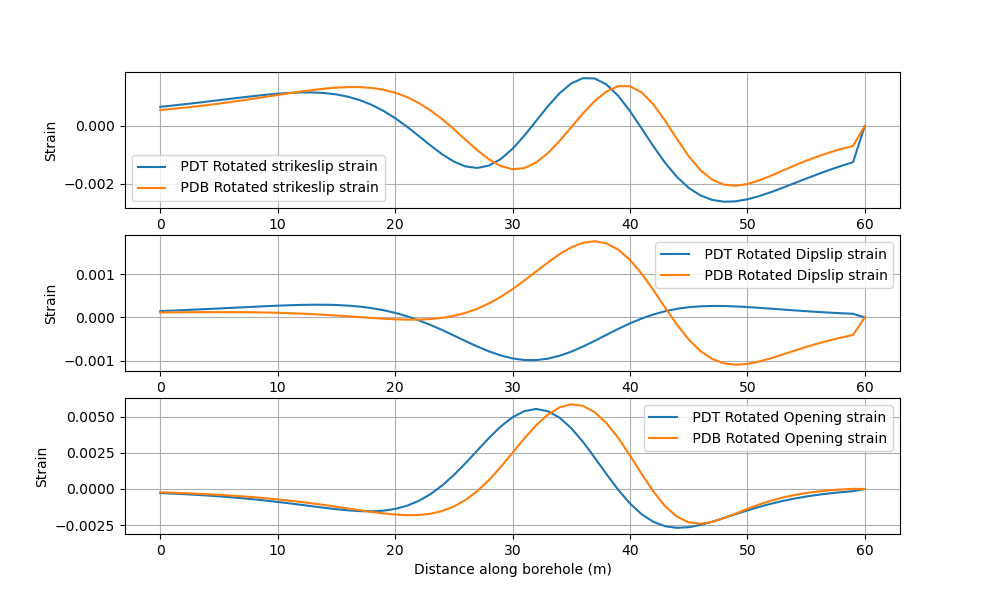

In [12]:
# Make some plots of the modeled strains
pdtdistance_along_line = np.sqrt( (pdtobsx-pdtobsx[0])**2 + (pdtobsy-pdtobsy[0])**2 + (pdtobsz-pdtobsz[0])**2)
pdbdistance_along_line = np.sqrt( (pdbobsx-pdbobsx[0])**2 + (pdbobsy-pdbobsy[0])**2 + (pdbobsz-pdbobsz[0])**2)
fig,ax = plt.subplots(3,1,figsize=(10,6))
ax[0].plot(pdtdistance_along_line,pdtstrain_grid_new1[:,0],label=' PDT Rotated strikeslip strain')
ax[0].plot(pdbdistance_along_line,pdbstrain_grid_new1[:,0],label=' PDB Rotated strikeslip strain')
# ax[0].plot(distance_along_line,strain_grid1[:,0],label='Modeled Exx Strain')
ax[0].set_xlabel('Distance along borehole (m)')
ax[0].set_ylabel('Strain')
ax[0].grid()
ax[0].legend()
ax[1].plot(pdtdistance_along_line,pdtstrain_grid_new2[:,0],label=' PDT Rotated Dipslip strain')
ax[1].plot(pdbdistance_along_line,pdbstrain_grid_new2[:,0],label=' PDB Rotated Dipslip strain')
# ax[0].plot(distance_along_line,strain_grid2[:,0],label='Modeled Exx Strain')
ax[1].set_xlabel('Distance along borehole (m)')
ax[1].set_ylabel('Strain')
ax[1].grid()
ax[1].legend()
ax[2].plot(pdtdistance_along_line,pdtstrain_grid_new3[:,0],label=' PDT Rotated Opening strain')
ax[2].plot(pdbdistance_along_line,pdbstrain_grid_new3[:,0],label=' PDB Rotated Opening strain')
# ax[0].plot(distance_along_line,strain_grid2[:,0],label='Modeled Exx Strain')
ax[2].set_xlabel('Distance along borehole (m)')
ax[2].set_ylabel('Strain')
ax[2].grid()
ax[2].legend()

In [13]:
# Read in DAS data
df_fullT = pd.read_pickle('/home/spri902/EGS_Collab/4850/results/maystim/processed_DAS/lpFilter/wellPDT/maystim22_26_combined_full')
df_fullB = pd.read_pickle('/home/spri902/EGS_Collab/4850/results/maystim/processed_DAS/lpFilter/wellPDB/maystim22_26_combined_full')
dasScaler = 116.0
df_fullT = df_fullT.multiply(dasScaler)
df_fullB = df_fullB.multiply(dasScaler)
df_fullT = detrend(df_fullT,axis=0,type='linear')
df_fullB = detrend(df_fullB,axis=0,type='linear')

wn     = ['OT','OB','PST','PSB','PDB','PDT']
nfile_list = sorted(os.walk('/data1/parker/EGS_iDAS'))
nfile_list = nfile_list[1:]
#file_list = file_list[1:]
nfile_list = [group[2] for group in nfile_list]
nfile_list = [item for sublist in nfile_list for item in sublist]
# [file_list.append(f) for f in nfile_list]
fd = [name.split("_") for name in nfile_list]
fl = [fd[file][2].split(".") for file in range(len(fd))]
fl = [el[0] for el in fl]
DASdates = [datetime.strptime(d,'%y%m%d%H%M%S') for d in sorted(fl)]
# these are files that get skipped during the low pass filtering process and so the dates need to be removed 
ind2rem = [0, 90, 91, 257, 258, 1571, 1572, 3082, 3083, 5085, 5086, 5599, 5600, 5961, 5962, 7623, 7624, 8841, 8842, 9562]
# remove in reverse so that the indices remain in the correct order for removal
for index in sorted(ind2rem,reverse=True):
    del DASdates[index]

directory = sorted(os.walk('/home/spri902/mayCASSM'))
CASSMdates = [datetime.strptime(d,'%Y%m%d%H%M%S') for d in sorted(directory[0][1])]
chansT=np.linspace(0,df_fullT.shape[1] - 1,df_fullT.shape[1]).astype(int)
chansB=np.linspace(0,df_fullB.shape[1] - 1,df_fullB.shape[1]).astype(int)
stimbeg = [96, 224, 352, 472, 507]
stimfin = [106, 232, 368, 475, 512]
stimbegLines = itemgetter(*stimbeg)(CASSMdates)
stimfinLines = itemgetter(*stimfin)(CASSMdates)

dasdnums = mdates.date2num(DASdates)
cassmdnums = mdates.date2num(CASSMdates)
dasd = pd.date_range(start=DASdates[0],end=DASdates[-1],periods=len(cassmdnums[:-2]))
# Integrate strain rates to strain
df_strainT = cumulative_trapezoid(df_fullT,axis=0,initial=0)
df_strainB = cumulative_trapezoid(df_fullB,axis=0,initial=0) 

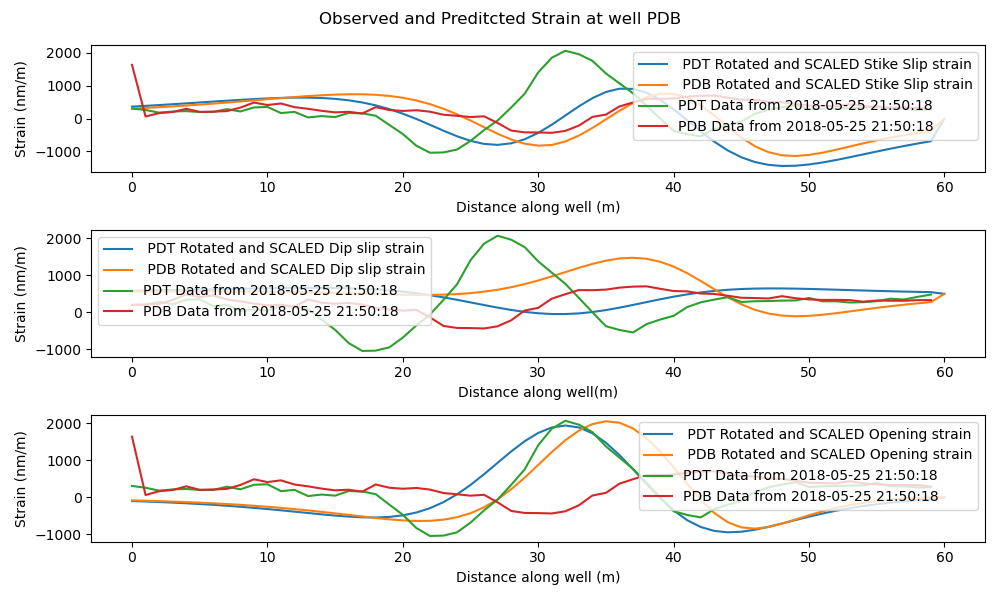

In [15]:
# Make some plots of the modeled XX strains and DAS data
# These need scaling and translating to appear on the same plot
fig, ax = plt.subplots(3,1,figsize=(10,6))
fig.suptitle('Observed and Preditcted Strain at well PDB')
ax[0].plot(pdtdistance_along_line,pdtstrain_grid_new1[:,0]*550000,label=' PDT Rotated and SCALED Stike Slip strain')
ax[0].plot(pdbdistance_along_line,pdbstrain_grid_new1[:,0]*550000,label=' PDB Rotated and SCALED Stike Slip strain')
ax[0].plot(chansT[:60],df_strainT[8565,:60],label=f'PDT Data from {DASdates[8565]}')
ax[0].plot(chansB[:60],df_strainB[8565,:60],label=f'PDB Data from {DASdates[8565]}')
# ax[0].plot(chansT[:60],df_strain_intT[511,:60],label=f'Data from {CASSMdates[511]}')
ax[0].set_xlabel('Distance along well (m)')
ax[0].set_ylabel('Strain (nm/m)')

ax[0].legend()

ax[1].plot(pdtdistance_along_line,(pdtstrain_grid_new2[:,0]*550000)+500,label=' PDT Rotated and SCALED Dip slip strain')
ax[1].plot(pdbdistance_along_line,(pdbstrain_grid_new2[:,0]*550000)+500,label=' PDB Rotated and SCALED Dip slip strain')
ax[1].plot(chansT[:60],df_strainT[8565,5:65],label=f'PDT Data from {DASdates[8565]}')
ax[1].plot(chansB[:60],df_strainB[8565,5:65],label=f'PDB Data from {DASdates[8565]}')
# ax[1].plot(chansT[4:64],df_strain_intT[511,:60],label=f'Data from {CASSMdates[511]}')
ax[1].set_xlabel('Distance along well(m)')
ax[1].set_ylabel('Strain (nm/m)')

ax[1].legend()

ax[2].plot(pdtdistance_along_line,(pdtstrain_grid_new3[:,0]*350000),label=' PDT Rotated and SCALED Opening strain')
ax[2].plot(pdbdistance_along_line,(pdbstrain_grid_new3[:,0]*350000),label=' PDB Rotated and SCALED Opening strain')
ax[2].plot(chansT[:60],df_strainT[8565,0:60],label=f'PDT Data from {DASdates[8565]}')
ax[2].plot(chansB[:60],df_strainB[8565,0:60],label=f'PDB Data from {DASdates[8565]}')
# ax[2].plot(chansT[:60],df_strain_intT[511,:60],label=f'Data from {CASSMdates[511]}')
ax[2].set_xlabel('Distance along well (m)')
ax[2].set_ylabel('Strain (nm/m)')

ax[2].legend()
fig.tight_layout()

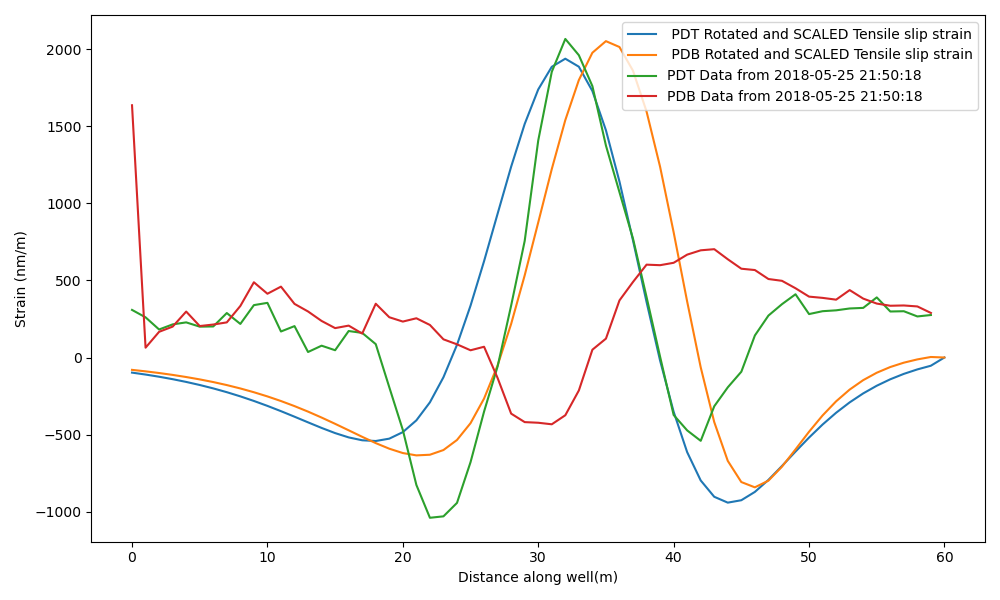

In [17]:
# Look at just the opening mode
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(pdtdistance_along_line,(pdtstrain_grid_new3[:,0]*350000),label=' PDT Rotated and SCALED Tensile slip strain')
ax.plot(pdbdistance_along_line,(pdbstrain_grid_new3[:,0]*350000),label=' PDB Rotated and SCALED Tensile slip strain')
# ax.plot(chansT[:60],df_strainT[8444,5:65],label=f'Data from {DASdates[8444]}')
ax.plot(chansT[:60],df_strainT[8565,:60],label=f'PDT Data from {DASdates[8565]}')
ax.plot(chansB[:60],df_strainB[8565,:60],label=f'PDB Data from {DASdates[8565]}')
# ax.plot(chansT[:60],df_strainT[7865,5:65],label=f'Data from {DASdates[7865]}')
ax.set_xlabel('Distance along well(m)')
ax.set_ylabel('Strain (nm/m)')

ax.legend()
fig.tight_layout()

In [20]:
# Now do an inversion with the summed elements 

# G = np.vstack([np.zeros_like(strain_grid_new1[:-1,0]),strain_grid_new2[:-1,0],np.zeros_like(strain_grid_new3[:-1,0])]).T
pdtG = np.vstack([pdtstrain_grid_new1[:-1,0],pdtstrain_grid_new2[:-1,0],pdtstrain_grid_new3[:-1,0]]).T
pdbG = np.vstack([pdbstrain_grid_new1[:-1,0],pdbstrain_grid_new2[:-1,0],pdbstrain_grid_new3[:-1,0]]).T
# G = strain_grid_new2[:-1,0]
pdtd = df_strainT[8565,0:60]
pdbd = df_strainB[8565,0:60]
# d = df_strainT[8444,0:60]
pdtm = lstsq(pdtG,pdtd)
pdbm = lstsq(pdbG,pdbd)
print(f'Model estimates for PDT {pdtm[0]}')
print(f'Model estimates for PDB {pdbm[0]}')


Model estimates for PDT [ -67400.50724952 1161703.55986901  422938.98212696]
Model estimates for PDB [ -14662.45215255  257853.00267827 -104160.84047269]


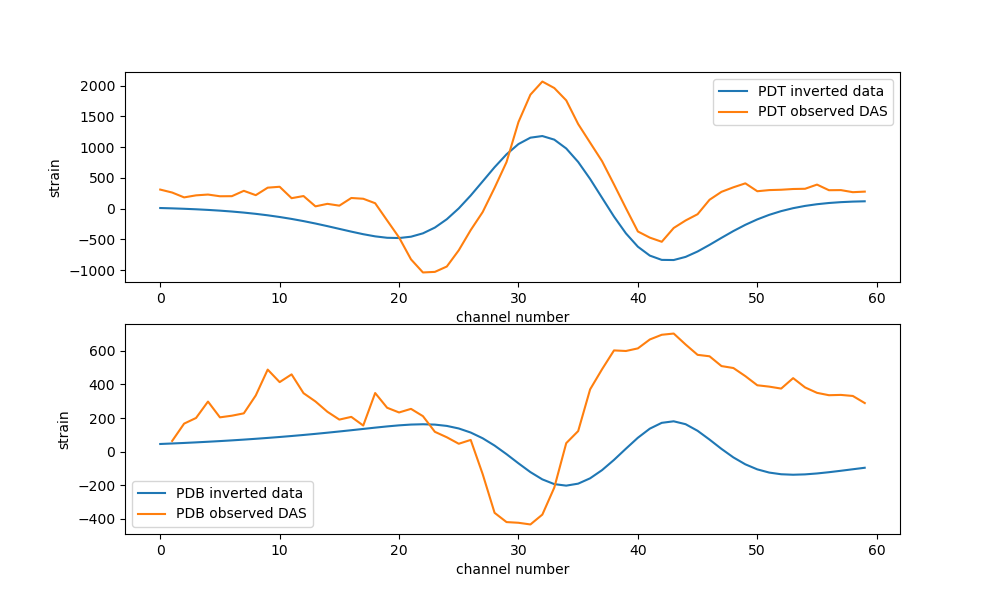

In [21]:
# Make some plots of the inversion results with the summed elements
fig, ax = plt.subplots(2,1,figsize=(10,6))
ax[0].plot(pdtdistance_along_line[:-1],np.dot(pdtG,pdtm[0]),label='PDT inverted data')
ax[0].plot(chansT[:60],pdtd,label='PDT observed DAS')
ax[1].plot(pdbdistance_along_line[:-1],np.dot(pdbG,pdbm[0]),label='PDB inverted data')
ax[1].plot(chansB[1:60],pdbd[1:],label='PDB observed DAS')
ax[0].set_xlabel('channel number')
ax[0].set_ylabel('strain')
ax[0].legend()
ax[1].set_xlabel('channel number')
ax[1].set_ylabel('strain')
ax[1].legend()

In [22]:
# For fun check results with SVD using all 3 singular values in the SVD (same result as lstsq)
pval=3
U,S,Vt = svd(pdtG,full_matrices=False,lapack_driver='gesvd')
Up = U[:,:pval]
Sp = S[:pval]
Vp = Vt[:pval,:]

gInv = np.dot(np.dot(Vp.T,np.linalg.inv(np.diag(Sp))),Up.T) # do the generalized inverse
mInv = np.dot(gInv,pdtd) # estimate model parameters 
dp = pdtG @ mInv
covd = np.diag(np.dot(dp**2,np.eye(len(pdtd)))) # Turn covd back into a matrix

covmn = np.dot(gInv,np.dot(covd.T,gInv.T))
dpn   = np.dot(pdtG,mInv)
l2norm = np.sqrt(np.sum((pdtd - dp)**2))
stdn = np.sqrt(np.diag(covmn))

In [23]:
print(f'L2norm is {l2norm} \n')
print(f'Model estimates are {mInv} \n')
print(f'Standard deviation of model estimates are {stdn}')

L2norm is 3736.72214964425 

Model estimates are [ -67400.50724952 1161703.55986902  422938.98212696] 

Standard deviation of model estimates are [ 39293.0153646  476919.67504329 105614.22694005]


In [24]:
# this will get more complicated but start a function to do inversions for multiple wells at the same time and use individual elements as model parameters
def buildG(strainMats,numwells,strain_comp,mode):
    '''   
    build a G matrix that is Km x n where:
    K is the number of wells 
    m is the number of measurement points in the wels
    n is the number of elements in the mesh

    Usage:
    strainMats = list of strain models from Ben's code
    numwells = number of wells in strainMat
    strain_comp = 0, 1, 2, 3, 4 , 5 (xx,yy,zz,xy,xz,yz)
    mode = 0, 1, 2 (strikeslip, dipslip, opening)
    '''
    bigG = np.zeros((strainMats.shape[0],strainMats.shape[2]))
    bigG = strainMats[:,strain_comp,:,mode]
    return bigG


In [25]:
bigG = buildG(pdtstrain_mat,1,0,0)

In [26]:
mest = lstsq(bigG[:-1,:],df_strainB[8565,0:60])

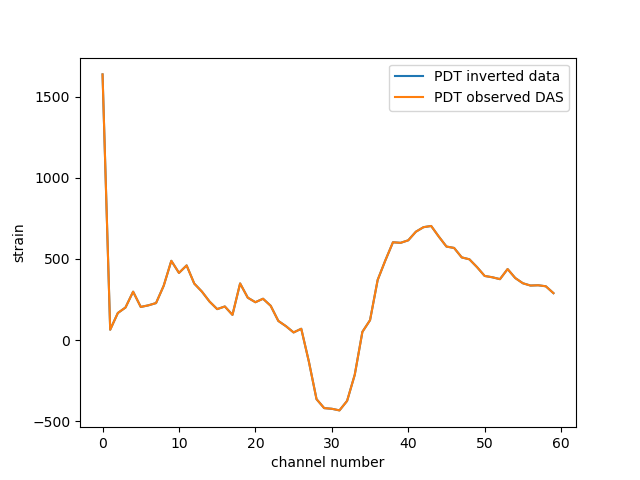

In [27]:
plt.figure()
plt.plot(bigG[:-1,:] @ mest[0],label='PDT inverted data')
plt.plot(df_strainB[8565,0:60],label='PDT observed DAS')
plt.xlabel('channel number')
plt.ylabel('strain')
plt.legend()